In [3]:
import torch
import pointnet2_utils
import pytorch_utils as pt_utils

In [4]:
import numpy as np
import os
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)  # If you changed the current working dir, this will take you back to the workbook dir.

BASE_DIR = os.path.join(workbookDir,os.pardir)
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
from pc_util import random_sampling, read_ply




def preprocess_point_cloud(point_cloud):
    ''' Prepare the numpy point cloud (N,3) for forward pass '''
    point_cloud = point_cloud[:,0:3] # do not use color for now
    floor_height = np.percentile(point_cloud[:,2],0.99)
    height = point_cloud[:,2] - floor_height
    point_cloud = np.concatenate([point_cloud, np.expand_dims(height, 1)],1) # (N,4) or (N,7)
    point_cloud = random_sampling(point_cloud, 20000)
    pc = np.expand_dims(point_cloud.astype(np.float32), 0) # (1,40000,4)
    return pc


demo_dir = os.path.join(BASE_DIR, 'demo_files/sunrgbd_results')
pc_path = os.path.join(demo_dir, '000000_pc.ply')

point_cloud = read_ply(pc_path)
pc = preprocess_point_cloud(point_cloud)
print('Loaded point cloud data: %s'%(pc_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
xyz = torch.from_numpy(pc).to(device)#{'point_clouds': torch.from_numpy(pc).to(device)}
sample_CUDA = pointnet2_utils.furthest_point_sample(xyz, 2048)

workbookDir: /home/gundo0102/votenet/votenet/pointnet2
Loaded point cloud data: /home/gundo0102/votenet/votenet/pointnet2/../demo_files/sunrgbd_results/000000_pc.ply


In [5]:
sample_CUDA.shape

torch.Size([1, 2048])

In [6]:
"""
Farthest point sampling
"""
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

def plot_points(points, ax=None, style={'marker': 'o', 'color':'b'}, label=False):
    """plots a set of points, with optional arguments for axes and style"""
    if ax==None:
        ax = plt.gca()
    for ind, p in enumerate(points[0]):
        #ax.plot(p[0], p[1], **style)
        if ind >10 and ind % 10 != 0:
            continue
        ax.scatter3D(p[0], p[1], p[2], **style);
        if label:
            ax.text(points[0], points[1], points[2], s=ind, horizontalalignment='center', verticalalignment='center')
    #ax.set_xlim(-1.1, 1.1)
    #ax.set_ylim(-1.1, 1.1)
    #ax.set_zlim(-1.1, 1.1)

    
import math
import random

def create_ball_points(n):
    point_set = []
    for i in range(n):
        for j in range(n):
            point_set.append([math.cos(2 * math.pi / n * i) * math.cos(2 * math.pi / n * j), 
                              math.sin(2 * math.pi / n * i) * math.cos(2 * math.pi / n * j),
                              math.sin(2 * math.pi / n * j)])
    return point_set

def distance(p1, p2):
    #return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)**0.5
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def incremental_farthest_search(points, k):
    
    remaining_points = points[:]    
    remaining_points_1 = remaining_points[0]
    #solution_set = np.array([])
    ind = random.randint(0, len(remaining_points_1) - 1)    
    #solution_set = np.expand_dims(np.expand_dims(remaining_points[0,ind],0),0)
    solution_set = np.expand_dims(remaining_points_1[ind],0)
    print(solution_set)
    print(remaining_points_1.shape)
    remaining_points_1 = np.delete(remaining_points_1, ind, 0)
    #solution_set.append(remaining_points.pop(random.randint(0, len(remaining_points) - 1)))
    
    for iLoop in range(k - 1):
        distances = [distance(p, solution_set[0]) for p in remaining_points_1]
        print("Current loop:", iLoop)
        
        for i, p in enumerate(remaining_points_1):
            for j, s in enumerate(solution_set):
                distances[i] = min(distances[i], distance(p,s))
        sample = np.expand_dims(remaining_points_1[distances.index(max(distances))],0)
        solution_set = np.append(solution_set, sample, axis = 0)
        
        #solution_set.append(remaining_points[distances.index(max(distances))])
    return np.expand_dims(solution_set,0)


[[1.1519798  4.2882795  0.22067338]]
(20000, 3)
Current loop: 0
Current loop: 1
Current loop: 2
Current loop: 3
Current loop: 4
Current loop: 5
Current loop: 6


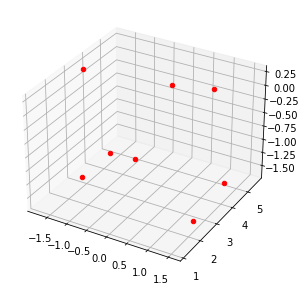

In [63]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection='3d')
pc_3d = pc[:,:,0:3]
#np.expand_dims(np.expand_dims(pc_3d[0,100],0),0).shape
sample_noncuda = incremental_farthest_search(pc_3d, 8)
#print(sample_noncuda)

#plot_points(pc, ax)
plot_points(sample_noncuda, style={'marker': 'o', 'color':'r'})

In [49]:
def uniform_sample(points, k):
    
    remaining_points = points[:]    
    remaining_points_1 = remaining_points[0]
    #solution_set = np.array([])
    ind = random.randint(0, len(remaining_points_1) - 1)    
    print(ind)
    #solution_set = np.expand_dims(np.expand_dims(remaining_points[0,ind],0),0)
    
    random_sample = remaining_points_1[ind]
    distances = [distance(p, random_sample) for p in remaining_points_1]
    
    max_ind = distances.index(max(distances))
    print(max_ind)
    end_sample = remaining_points_1[max_ind]
    distances = [distance(p, end_sample) for p in remaining_points_1]
    
    x = np.argsort(distances)
    print(x)
    
    num_pc = points.shape[1]
    step = int((num_pc-1)/(k-1))
    print(step)
    
    solution_set = np.expand_dims(end_sample,0)
    
    for i, p in enumerate(x):
        if i % step == 0 and i > 0:
            print(i)
            solution_set = np.append(solution_set, np.expand_dims(remaining_points_1[x[i]],0), axis = 0)
    
    return np.expand_dims(solution_set,0)

In [58]:
pc_3d = pc[:,:,0:3]
sample_uniform = uniform_sample(pc_3d,50)

12784
1904
[ 1904 15118  9210 ...  9838 12328  2035]
408
408
816
1224
1632
2040
2448
2856
3264
3672
4080
4488
4896
5304
5712
6120
6528
6936
7344
7752
8160
8568
8976
9384
9792
10200
10608
11016
11424
11832
12240
12648
13056
13464
13872
14280
14688
15096
15504
15912
16320
16728
17136
17544
17952
18360
18768
19176
19584
19992


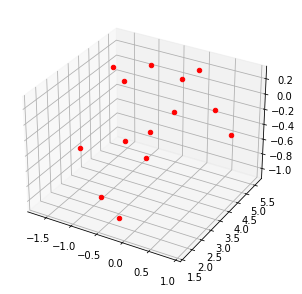

In [60]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection='3d')
plot_points(sample_uniform, style={'marker': 'o', 'color':'r'})

In [38]:
sample_uniform.shape

(1, 10, 3)